<a href="https://colab.research.google.com/github/cxbxmxcx/EvolutionaryDeepLearning/blob/main/EDL_8_5_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part of VAE source obtained from https://github.com/mtliba/VAE-deconv-keras/blob/master/main.py


In [ ]:
import math

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import LayerNormalization
from keras.models import Model
from keras.datasets import fashion_mnist
from keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from keras import backend as K
import tensorflow as tf

#from plot import plot_results
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output
plt.gray()

<Figure size 432x288 with 0 Axes>

In [ ]:
#@title VAE Sampling
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    #epsilon = K.random_binomial(shape=(batch, dim))
    #epsilon = K.random_bernoulli(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

4431872/4422102 [==============================] - 0s 0us/step


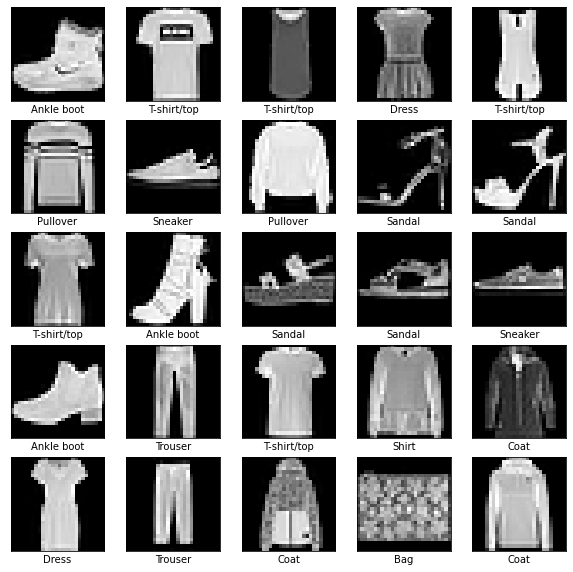

In [ ]:
#@title Load Fashion dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def plot_data(num_images, images, labels):
  grid = math.ceil(math.sqrt(num_images))
  plt.figure(figsize=(grid*2,grid*2))
  for i in range(num_images):
      plt.subplot(grid,grid,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)     
      plt.imshow(images[i].reshape(image_size,image_size))
      plt.xlabel(class_names[labels[i]])      
  plt.show()

plot_data(25, x_train, y_train)

In [ ]:
#@title Network Hyperparameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 5

In [ ]:
#@title Start Encoder Convolution Layers
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

In [ ]:
#@title Generate Sampling Inputs and Layer
# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(
    sampling, 
    output_shape=(latent_dim,), 
    name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [ ]:
#@title Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289 

In [ ]:
#@title Instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

use_mse = False
if use_mse:
  reconstruction_loss = mse(
      K.flatten(inputs), K.flatten(outputs))
else:
  reconstruction_loss = binary_crossentropy(
      K.flatten(inputs), K.flatten(outputs))

reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(tf.math.add(reconstruction_loss, kl_loss))
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          69076       ['encoder_input[0][0]']          
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    65089       ['encoder[0][2]']                
                                                                                                

In [ ]:
#@title History and Plot helpers
history_loss = []
history_val_loss = []

def add_history(history):  
  history_loss.append(history.history["loss"])
  history_val_loss.append(history.history["val_loss"])  

def reset_history():
  global history_loss
  global history_val_loss
  history_loss = []
  history_val_loss = []
  return []

def plot_results(num_images, images, labels, history):
  add_history(history)
  grid = math.ceil(math.sqrt(num_images))
  plt.figure(figsize=(grid*2,grid*2))
  for i in range(num_images):
      plt.subplot(grid,grid,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)     
      plt.imshow(images[i].reshape(image_size,image_size))
      plt.xlabel(class_names[labels[i]])      
  plt.show()
  plt.plot(np.array(history_loss)/max(history_loss), label='normalized loss')
  plt.plot(np.array(history_val_loss)/max(history_val_loss), label='normalized val_loss')  
  plt.legend()
  plt.show()  

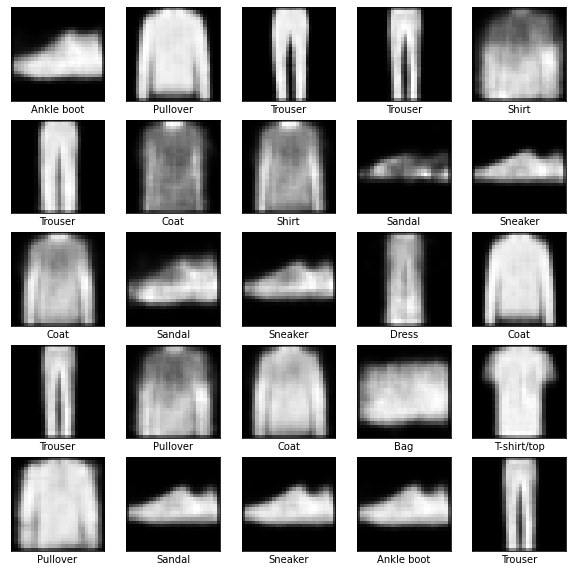

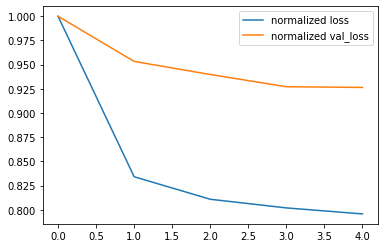

In [ ]:
#@title Training the VAE
history = reset_history()

for i in range(epochs):
  history = vae.fit(x_train,x_train, epochs=1, batch_size=batch_size, validation_data=(x_test, x_test, None))
  pred_images = vae.predict(x_test[:25])
  clear_output()
  plot_results(25, pred_images[:25], y_test[:25], history)

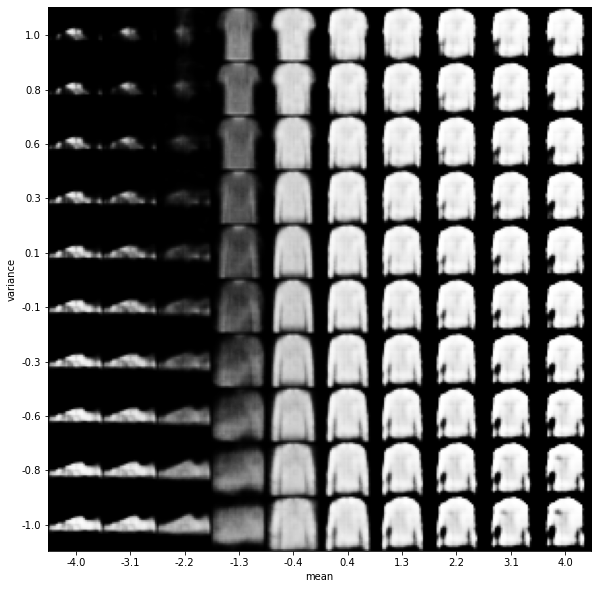

In [ ]:
#@title Display a 30x30 2D manifold of digits
n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("mean")
plt.ylabel("variance")
plt.imshow(figure)
plt.show()